In [1]:
import pandas as pd
import sqlite3
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
from scipy.stats import binom
import matplotlib.pyplot as plt


In [2]:
conn = sqlite3.connect('ca3.db')

In [3]:
def importa_file_csv(cartella, dataframe_titles, database):
    # connection with sqlite
    conn = sqlite3.connect(database)

    # Get all files in the folder
    file_cartella = os.listdir(cartella)

    # loop in folder
    for file in file_cartella:
        if file.endswith(".csv"):
            # get the tile from dictionary
            title = dataframe_titles.get(file)
            if title:
                # read csv in dataframe
                path_file = os.path.join(cartella, file)
                dataframe = pd.read_csv(path_file)

                # create tables in sqlite based on dataframe
                dataframe.to_sql(title, conn, if_exists='replace', index=False)

   
    
    



In [4]:
# specify where files are stored
folder_with_files = "ca2"

# dictionary with filenames and dataframe_titles
dataframe_titles = {
    'tipsho20_linear.csv': 'housing_price',
    'sts_copi_a_linear.csv': 'cost',
    'tipsna50_linear.csv': 'investment',
    'sdg_10_20_linear.csv': 'pro_capita_income',
    'nama_10_pe_linear.csv': 'population',
    'all_countries.csv':'countries'
}

# name database SQLite
database = "ca3.db"

# call the function to import files in sqlite
importa_file_csv(folder_with_files, dataframe_titles, database)


In [5]:


# Dictionary with queries and dataframe names
queries = {
    'housing_price': "SELECT geo,TIME_PERIOD,OBS_VALUE as'housing_price' FROM  housing_price WHERE unit ='INX_A_AVG'",
    'cost': "SELECT geo,TIME_PERIOD,OBS_VALUE as 'Output price index in construction' FROM cost WHERE unit = 'I15' AND indic_bt ='CSTO' GROUP BY geo,TIME_PERIOD,indic_bt",
    'investment': "SELECT geo,TIME_PERIOD,OBS_VALUE as 'investment in costruction' FROM investment",
    'pro_capita_income': "SELECT geo,TIME_PERIOD,OBS_VALUE as 'pro_capita__income'  FROM  pro_capita_income WHERE unit = 'PPS_EU27_2020_HAB' ",
    'population': "SELECT geo,TIME_PERIOD,OBS_VALUE as 'population'  FROM  population WHERE na_item ='POP_NC' AND unit = 'THS_PER'  GROUP BY geo,TIME_PERIOD",
    'countries': "SELECT `alpha-2` as `geo`, `alpha-3`, `sub-region` FROM countries"
}

# list for dataframe 
dataframes = []

# Loop attraverso le query e creazione dei dataframe
for name, query in queries.items():
    df = pd.read_sql_query(query, conn)
    dataframes.append(df)

# Merge dei dataframe utilizzando le colonne 'geo' e 'TIME_PERIOD' come chiavi (tranne per 'countries')
final = dataframes[0]  # Primo dataframe come base per il merge

for df in dataframes[1:]:
    if 'TIME_PERIOD' in df.columns:  # Controllo se 'TIME_PERIOD' è presente nel dataframe
        final = final.merge(df, on=['geo', 'TIME_PERIOD'])
    else:
        final = final.merge(df, on='geo')



In [6]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 0 to 477
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   geo                                 478 non-null    object 
 1   TIME_PERIOD                         478 non-null    int64  
 2   housing_price                       478 non-null    float64
 3   Output price index in construction  478 non-null    float64
 4   investment in costruction           478 non-null    float64
 5   pro_capita__income                  478 non-null    int64  
 6   population                          478 non-null    float64
 7   alpha-3                             478 non-null    object 
 8   sub-region                          478 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 37.3+ KB


In [7]:
final['geo'].unique()

array(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR',
       'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'NL', 'PL', 'PT', 'SE',
       'SI', 'SK'], dtype=object)

In [8]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 0 to 477
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   geo                                 478 non-null    object 
 1   TIME_PERIOD                         478 non-null    int64  
 2   housing_price                       478 non-null    float64
 3   Output price index in construction  478 non-null    float64
 4   investment in costruction           478 non-null    float64
 5   pro_capita__income                  478 non-null    int64  
 6   population                          478 non-null    float64
 7   alpha-3                             478 non-null    object 
 8   sub-region                          478 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 37.3+ KB


In [9]:
mean_Y = final['pro_capita__income'].mean()

# creating a binomial column that will store the valu Y if the pro capita income is above the average and N if otherwise
final['pro_capita__income_cat'] = final['pro_capita__income'].apply(lambda x: 'Y' if x > mean_Y else x)

In [10]:
final.describe()

,TIME_PERIOD,housing_price,Output price index in construction,investment in costruction,pro_capita__income,population
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000
mean,2011.188285,99.607050,95.164226,4.507322,17926.830544,16638.086172
std,6.069316,27.001756,15.125256,2.056214,5852.725683,22490.786568
min,2000.000000,29.330000,43.000000,1.300000,4905.000000,436.980000
25%,2006.000000,83.975000,86.650000,3.000000,13875.750000,3450.007500
50%,2011.000000,100.000000,98.100000,4.200000,17765.500000,7760.530000
75%,2016.000000,114.220000,103.175000,5.700000,22051.000000,11196.500000
max,2021.000000,208.040000,160.700000,13.500000,36319.000000,83196.000000


In [11]:
final.head()

,geo,TIME_PERIOD,housing_price,Output price index in construction,investment in costruction,pro_capita__income,population,alpha-3,sub-region,pro_capita__income_cat
0,AT,2000,60.36,69.4,5.3,18096,8011.57,AUT,Western Europe,Y
1,AT,2001,60.82,70.5,4.9,18038,8042.29,AUT,Western Europe,Y
2,AT,2002,61.21,71.4,4.6,18604,8082.12,AUT,Western Europe,Y
3,AT,2003,61.36,72.4,4.4,19575,8118.25,AUT,Western Europe,Y
4,AT,2004,60.21,74.4,4.4,20217,8169.44,AUT,Western Europe,Y


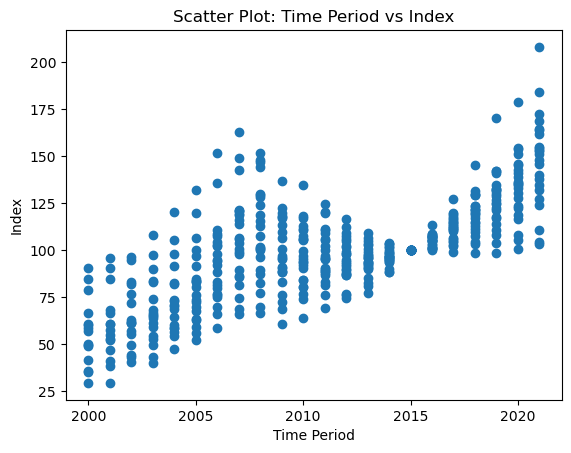

In [12]:
# plot TIME_PERIOD vs house_price_index
plt.scatter(final['TIME_PERIOD'], final['housing_price'])

# label
plt.xlabel('Time Period')
plt.ylabel('Index')

plt.title('Scatter Plot: Time Period vs Index')

plt.show()

In [13]:
group1 = final[final['sub-region'] == 'Western Europe']['housing_price']
group2 = final[final['sub-region'] == 'Eastern Europe']['housing_price']
group3 = final[final['sub-region'] == 'Southern Europe']['housing_price']
group4 = final[final['sub-region'] == 'Northern Europe']['housing_price']


In [14]:
import scipy.stats as stats


# confidence interval in the sub groups
conf_int_group1 = stats.t.interval(0.95, len(group1)-1, loc=group1.mean(), scale=stats.sem(group1))
conf_int_group2 = stats.t.interval(0.95, len(group2)-1, loc=group2.mean(), scale=stats.sem(group2))
conf_int_group3 = stats.t.interval(0.95, len(group3)-1, loc=group3.mean(), scale=stats.sem(group3))
conf_int_group4 = stats.t.interval(0.95, len(group4)-1, loc=group4.mean(), scale=stats.sem(group4))

# print results
print("Confidence Interval housing price index Western Europe (95%):", conf_int_group1)
print("Confidence Interval housing price index Eastern Europe:", conf_int_group2)
print("Confidence Interval housing price index Southern Europe", conf_int_group3)
print("Confidence Interval housing price index Northern Europe:", conf_int_group4)

Confidence Interval housing price index Western Europe (95%): (89.61409565144874, 98.80889647453554)
Confidence Interval housing price index Eastern Europe: (98.97100030450174, 111.51723498961586)
Confidence Interval housing price index Southern Europe (104.21864941095238, 112.43351553750124)
Confidence Interval housing price index Northern Europe: (89.82739099864801, 99.42281034363387)


In [15]:
final_2015= final[final['TIME_PERIOD'] >= 2015]

In [16]:
group5 = final_2015[final_2015['sub-region'] == 'Western Europe']['housing_price']
group6 = final_2015[final_2015['sub-region'] == 'Eastern Europe']['housing_price']
group7 = final_2015[final_2015['sub-region'] == 'Southern Europe']['housing_price']
group8 = final_2015[final_2015['sub-region'] == 'Northern Europe']['housing_price']


In [17]:
import scipy.stats as stats


# confidence interval in the sub groups
conf_int_group1 = stats.t.interval(0.95, len(group5)-1, loc=group5.mean(), scale=stats.sem(group5))
conf_int_group2 = stats.t.interval(0.95, len(group6)-1, loc=group6.mean(), scale=stats.sem(group6))
conf_int_group3 = stats.t.interval(0.95, len(group7)-1, loc=group7.mean(), scale=stats.sem(group7))
conf_int_group4 = stats.t.interval(0.95, len(group8)-1, loc=group8.mean(), scale=stats.sem(group8))

# print results
print("Confidence Interval housing price index Western Europe (95%):", conf_int_group1)
print("Confidence Interval housing price index Eastern Europe:", conf_int_group2)
print("Confidence Interval housing price index Southern Europe", conf_int_group3)
print("Confidence Interval housing price index Northern Europe:", conf_int_group4)

Confidence Interval housing price index Western Europe (95%): (114.16615224909218, 125.8400382270983)
Confidence Interval housing price index Eastern Europe: (118.74992519940712, 139.44039738123797)
Confidence Interval housing price index Southern Europe (110.69227127018104, 123.49915730124755)
Confidence Interval housing price index Northern Europe: (114.41132029676913, 124.28418990731251)


# Description of variables

In [18]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings 
warnings.filterwarnings('ignore')

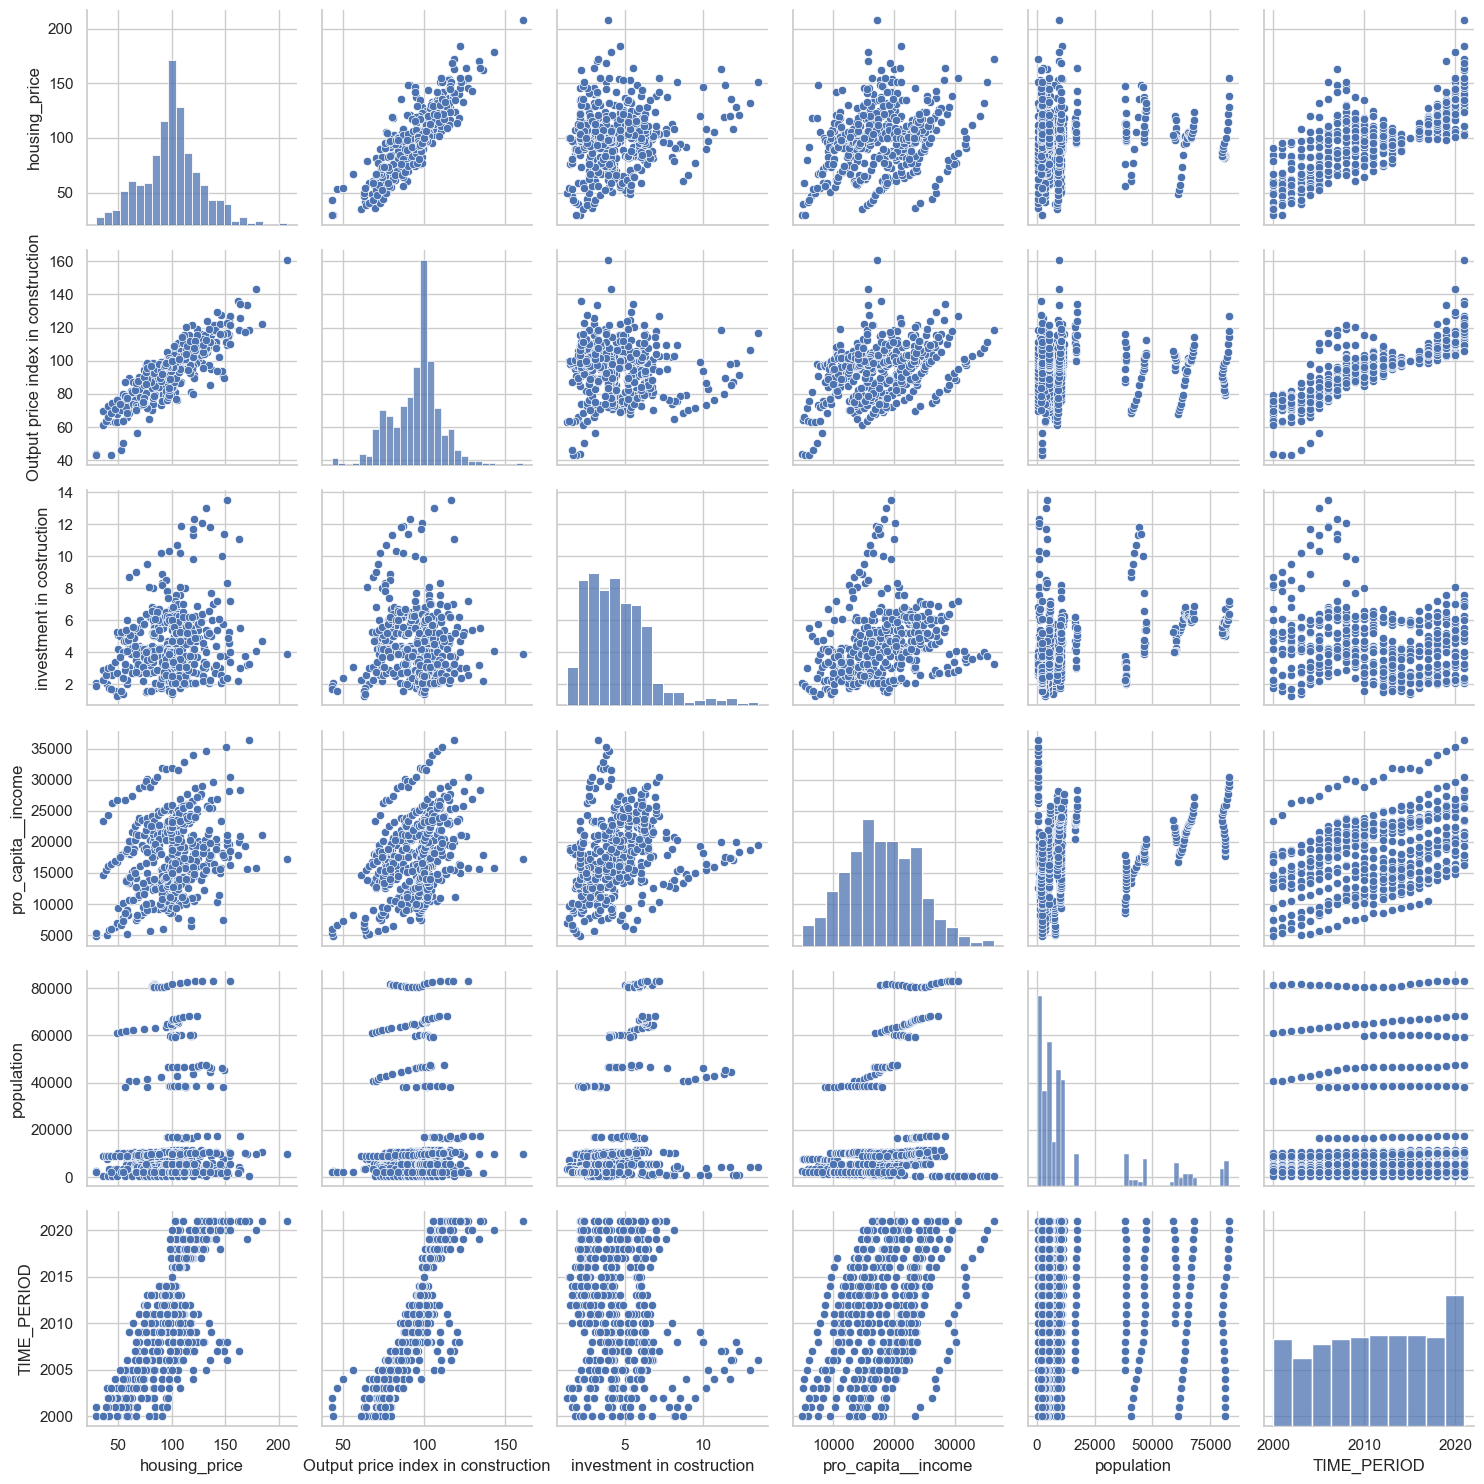

In [19]:
# Create plots to study the variables
sns.set(style='whitegrid', context='notebook')
# declare the columns for the plot
cols = ['housing_price', 'Output price index in construction', 'investment in costruction', 'pro_capita__income', 
        'population','TIME_PERIOD']
# Display the pairplot 
sns.pairplot(final[cols], height = 2.5)
plt.tight_layout()
plt.show()

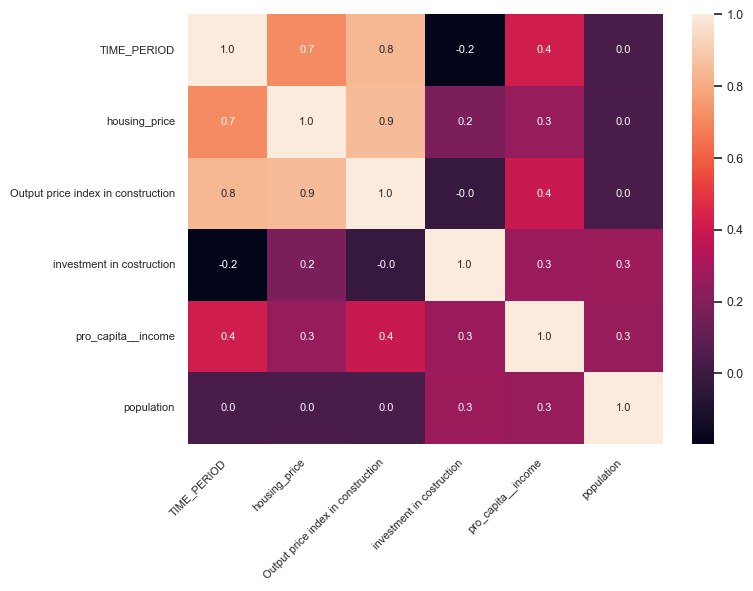

In [20]:
cm = final.corr()

# Configurazione del plot
sns.set(font_scale=0.8)
fig, ax = plt.subplots(figsize=(8, 6))

# Plot del heatmap con tutti i valori
sns.heatmap(cm, annot=True, fmt='.1f', annot_kws={'size': 8}, ax=ax)

# Personalizzazione delle etichette
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=8)

# Mostra il plot
plt.tight_layout()
plt.show()

In [21]:
from scipy.stats import pearsonr

variables = ['housing_price', 'Output price index in construction', 'TIME_PERIOD']

alpha = 0.05

for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        var1 = final[variables[i]]
        var2 = final[variables[j]]

        correlation, p_value = pearsonr(var1, var2)  # Pearson correlation test

        if p_value < alpha:  # interpretation of p value
            print(f"{variables[i]} and {variables[j]} are significantly correlated")
        else:
            print(f"{variables[i]} and {variables[j]} are not significantly correlated")


housing_price and Output price index in construction are significantly correlated
housing_price and TIME_PERIOD are significantly correlated
Output price index in construction and TIME_PERIOD are significantly correlated


In [22]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 0 to 477
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   geo                                 478 non-null    object 
 1   TIME_PERIOD                         478 non-null    int64  
 2   housing_price                       478 non-null    float64
 3   Output price index in construction  478 non-null    float64
 4   investment in costruction           478 non-null    float64
 5   pro_capita__income                  478 non-null    int64  
 6   population                          478 non-null    float64
 7   alpha-3                             478 non-null    object 
 8   sub-region                          478 non-null    object 
 9   pro_capita__income_cat              478 non-null    object 
dtypes: float64(4), int64(2), object(4)
memory usage: 41.1+ KB


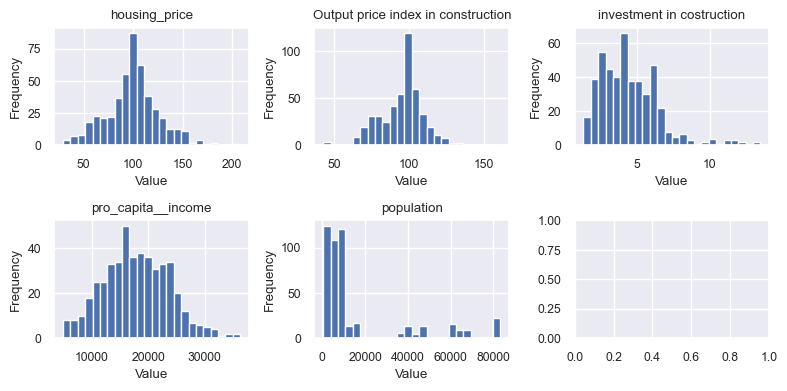

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(8, 4))

# Variables for plot
variables = ['housing_price', 'Output price index in construction', 'investment in costruction',
             'pro_capita__income', 'population']

# creation of histogram in loop
for i, ax in enumerate(axs.flat):
    if i < len(variables):
        variable = variables[i]
        ax.hist(final[variable].dropna(), bins=24)
        ax.set_title(variable)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')


plt.tight_layout()


plt.show()

In [24]:
Y = (final['pro_capita__income_cat'] == 'Y').sum()
Y


232

In [25]:
n=final['pro_capita__income_cat'].count()
n

478

In [26]:
p = Y/n
p

0.48535564853556484

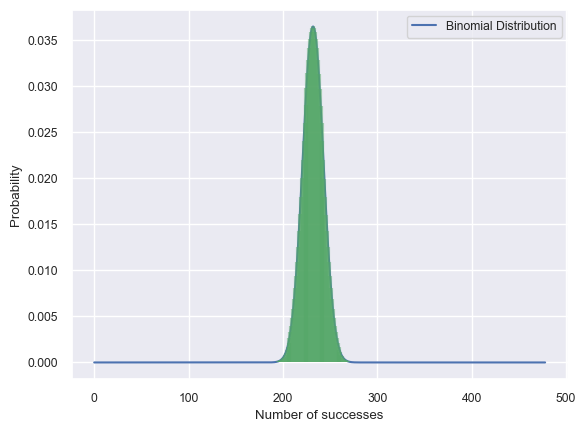

In [27]:
# calculate binomial values
binom_v = np.arange(0, n+1)
probability = binom.pmf(binom_v, n, p)

# plot the binomial distribution
plt.plot(binom_v, probability, ms=8, label='Binomial Distribution')
plt.vlines(binom_v, 0, probability, colors='g', lw=3, alpha=0.5)


# legend
plt.xlabel('Number of successes')
plt.ylabel('Probability')
plt.legend()


plt.show()


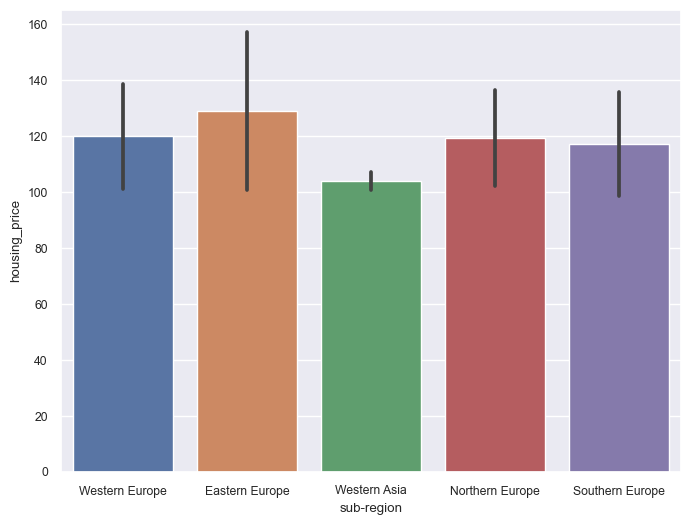

In [28]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(x="sub-region", y="housing_price", data=final_2015, ci="sd")

In [29]:
asia = final[final['sub-region']=='Western Asia']

In [30]:
asia['geo'].unique()

array(['CY'], dtype=object)

In [31]:
final['sub-region'].unique()

array(['Western Europe', 'Eastern Europe', 'Western Asia',
       'Northern Europe', 'Southern Europe'], dtype=object)

In [32]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 0 to 477
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   geo                                 478 non-null    object 
 1   TIME_PERIOD                         478 non-null    int64  
 2   housing_price                       478 non-null    float64
 3   Output price index in construction  478 non-null    float64
 4   investment in costruction           478 non-null    float64
 5   pro_capita__income                  478 non-null    int64  
 6   population                          478 non-null    float64
 7   alpha-3                             478 non-null    object 
 8   sub-region                          478 non-null    object 
 9   pro_capita__income_cat              478 non-null    object 
dtypes: float64(4), int64(2), object(4)
memory usage: 41.1+ KB


In [33]:
from scipy.stats import kruskal

statistic, p_value = kruskal(group5, group6, group7, group8)


print("Kruskal-Wallis Test - Statistic:", statistic)
print("Kruskal-Wallis Test - P-value:", p_value)


Kruskal-Wallis Test - Statistic: 3.6631348752312904
Kruskal-Wallis Test - P-value: 0.3002122201197875


In [34]:
statistic, p_value = kruskal(group1, group2, group3, group4)


print("Kruskal-Wallis Test - Statistic:", statistic)
print("Kruskal-Wallis Test - P-value:", p_value)

Kruskal-Wallis Test - Statistic: 25.961147242710382
Kruskal-Wallis Test - P-value: 9.717730593501133e-06


In [35]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 0 to 477
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   geo                                 478 non-null    object 
 1   TIME_PERIOD                         478 non-null    int64  
 2   housing_price                       478 non-null    float64
 3   Output price index in construction  478 non-null    float64
 4   investment in costruction           478 non-null    float64
 5   pro_capita__income                  478 non-null    int64  
 6   population                          478 non-null    float64
 7   alpha-3                             478 non-null    object 
 8   sub-region                          478 non-null    object 
 9   pro_capita__income_cat              478 non-null    object 
dtypes: float64(4), int64(2), object(4)
memory usage: 41.1+ KB


In [36]:
import scipy.stats as stats


# confidence interval
conf_int_group1 = stats.t.interval(0.95, len(group1)-1, loc=group1.mean(), scale=stats.sem(group1))
conf_int_group2 = stats.t.interval(0.95, len(group2)-1, loc=group2.mean(), scale=stats.sem(group2))
conf_int_group3 = stats.t.interval(0.95, len(group3)-1, loc=group3.mean(), scale=stats.sem(group3))
conf_int_group4 = stats.t.interval(0.95, len(group4)-1, loc=group4.mean(), scale=stats.sem(group4))

print("Confidence Interval housing price index Western Europe (95%):", conf_int_group1)
print("Confidence Interval housing price index Eastern Europe:", conf_int_group2)
print("Confidence Interval housing price index Southern Europe", conf_int_group3)
print("Confidence Interval housing price index Northern Europe:", conf_int_group4)

Confidence Interval housing price index Western Europe (95%): (89.61409565144874, 98.80889647453554)
Confidence Interval housing price index Eastern Europe: (98.97100030450174, 111.51723498961586)
Confidence Interval housing price index Southern Europe (104.21864941095238, 112.43351553750124)
Confidence Interval housing price index Northern Europe: (89.82739099864801, 99.42281034363387)


In [37]:
#create dataframe with only numerical variables for normalization
final_normalized= final.drop(columns=['geo','alpha-3','sub-region','pro_capita__income_cat'])

In [38]:
columns= final_normalized.columns

In [39]:
import scipy.stats as stats


variables = ['housing_price', 'Output price index in construction', 'investment in costruction', 'pro_capita__income', 'population']


for var in variables:   # Loop to test each variable
    
    data = final[var]
    
    
    _, p_value = stats.shapiro(data) #  p-value of Shapiro-Wilk test
    
    
    print(f'Variabile: {var}')
    print(f'P-value: {p_value}')
    if p_value > 0.05:
        print('La distribuzione può essere considerata approssimativamente normale.')
    else:
        print('La distribuzione non può essere considerata approssimativamente normale.')
    print('-----------------------------------')


Variabile: housing_price
P-value: 0.00019239714310970157
La distribuzione non può essere considerata approssimativamente normale.
-----------------------------------
Variabile: Output price index in construction
P-value: 5.093354005225592e-08
La distribuzione non può essere considerata approssimativamente normale.
-----------------------------------
Variabile: investment in costruction
P-value: 2.847506922382836e-16
La distribuzione non può essere considerata approssimativamente normale.
-----------------------------------
Variabile: pro_capita__income
P-value: 0.056435659527778625
La distribuzione può essere considerata approssimativamente normale.
-----------------------------------
Variabile: population
P-value: 1.7445733970045196e-29
La distribuzione non può essere considerata approssimativamente normale.
-----------------------------------


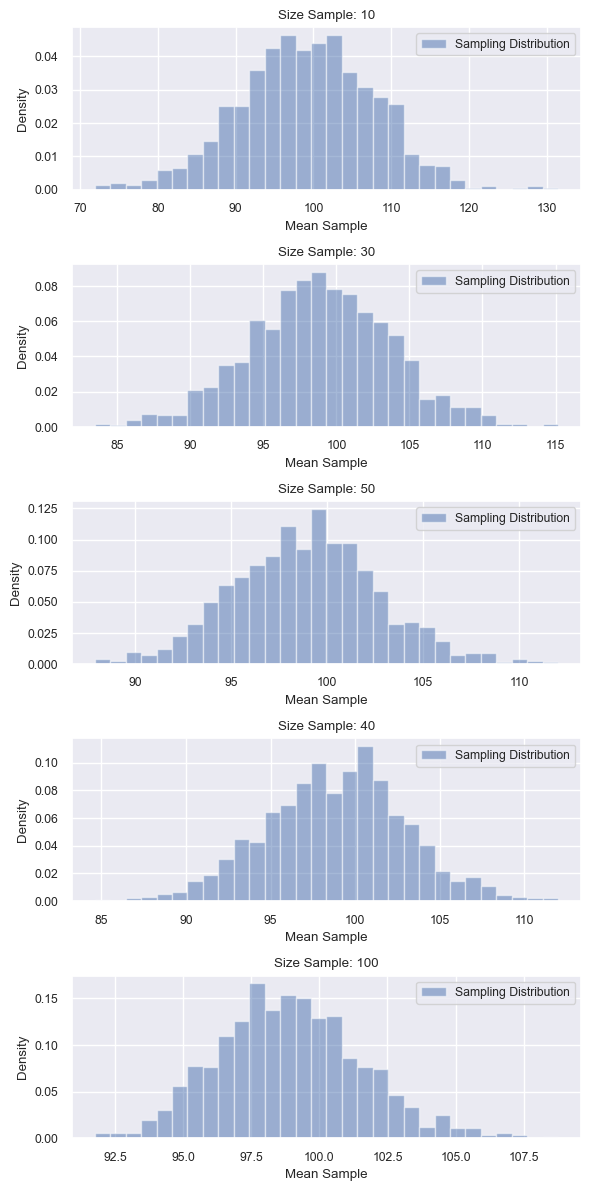

In [40]:

# Generate random sample from variable
index_housing = final['housing_price']
tot_obs = 478
sub_sample = np.random.choice(index_housing, size=tot_obs, replace=True)

# calculate mean sample
size_samples = [10, 30, 50, 40, 100]
mean_s = []

for n in size_samples:
    means = []
    for _ in range(1000):
        sample_n = np.random.choice(sub_sample, size=n, replace=True)
        mean_one = np.mean(sample_n)
        means.append(mean_one)
    mean_s.append(means)

# Plot of the sampling distribution
fig, axs = plt.subplots(len(size_samples), 1, figsize=(6, 12))

for i, n in enumerate(size_samples):
    axs[i].hist(mean_s[i], bins=30, density=True, alpha=0.5, label='Sampling Distribution')
    axs[i].set_title(f'Size Sample: {n}')
    axs[i].set_xlabel('Mean Sample')
    axs[i].set_ylabel('Density')
    axs[i].legend()


plt.tight_layout()
plt.show()


In [41]:
# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns for test and train dataset

final_normalized[columns] = scaler.fit_transform(final_normalized[columns])

In [42]:
final_normalized.head()

,TIME_PERIOD,housing_price,Output price index in construction,investment in costruction,pro_capita__income,population
0,0.000000,0.173633,0.224299,0.327869,0.419908,0.091526
1,0.047619,0.176207,0.233645,0.295082,0.418062,0.091897
2,0.095238,0.178390,0.241291,0.270492,0.436079,0.092378
3,0.142857,0.179229,0.249788,0.254098,0.466989,0.092815
4,0.190476,0.172794,0.266780,0.254098,0.487426,0.093433


# Regression

In [43]:
# train-test 70-30 split
df_train, df_test = train_test_split(final_normalized, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)


In [44]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('housing_price')
X_train = df_train

y_test = df_test.pop('housing_price')
X_test = df_test

In [45]:
# num of max features
len(X_train.columns)

5

In [46]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=3)             
rfe = rfe.fit(X_train, y_train)

In [47]:
# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('TIME_PERIOD', False, 2),
 ('Output price index in construction', True, 1),
 ('investment in costruction', True, 1),
 ('pro_capita__income', True, 1),
 ('population', False, 3)]

In [48]:
# predict prices of X_test
y_pred = rfe.predict(X_test)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.7689985154109054


In [49]:
# cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)



In [50]:
# range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 6))}]




In [51]:
# perform grid search

lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             


model_wg = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      



In [52]:
# fit the model
model_wg.fit(X_train, y_train)  

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5]}],
             return_train_score=True, scoring='r2', verbose=1)

In [53]:
# results
results = pd.DataFrame(model_wg.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005313,0.000801,0.001174,0.000253,1,{'n_features_to_select': 1},0.759459,0.831318,0.617456,0.610352,...,0.716041,0.087339,5,0.726299,0.703307,0.757239,0.755091,0.724543,0.733296,0.020363
1,0.004124,0.000367,0.001059,0.000162,2,{'n_features_to_select': 2},0.769115,0.835513,0.694861,0.658735,...,0.751180,0.065290,4,0.766648,0.747184,0.782152,0.786959,0.758437,0.768276,0.014737
2,0.003135,0.000021,0.000944,0.000006,3,{'n_features_to_select': 3},0.776822,0.857169,0.741469,0.701279,...,0.781396,0.056853,3,0.801763,0.779769,0.808889,0.814795,0.787628,0.798569,0.013062
3,0.002754,0.000146,0.001072,0.000161,4,{'n_features_to_select': 4},0.803628,0.879095,0.743694,0.728731,...,0.799202,0.056895,1,0.816260,0.795233,0.828460,0.829600,0.806020,0.815114,0.013170
4,0.002196,0.000572,0.001142,0.000361,5,{'n_features_to_select': 5},0.803765,0.877355,0.740411,0.729564,...,0.798190,0.056714,2,0.816262,0.795893,0.829175,0.829665,0.806583,0.815515,0.013055


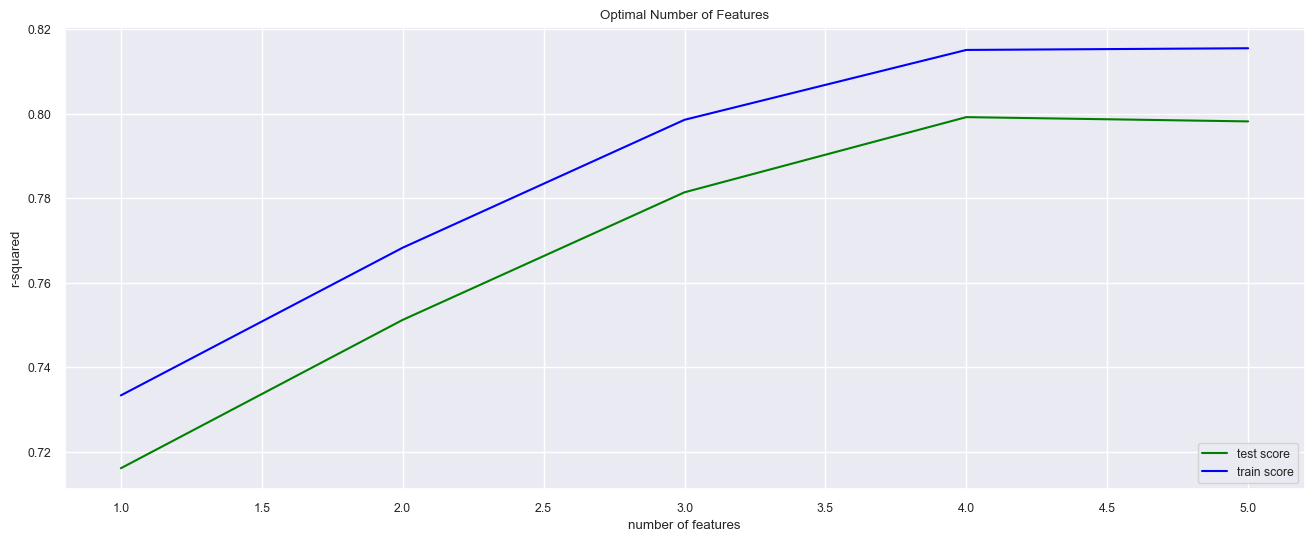

In [54]:
# plotting r2 values per each num feature 
plt.figure(figsize=(16,6))

plt.plot(results["param_n_features_to_select"], results["mean_test_score"],color='green')
plt.plot(results["param_n_features_to_select"], results["mean_train_score"],color='blue')
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='lower right')

In [55]:
n_features = 4

In [56]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [57]:
rfe = RFE(lm, n_features_to_select=n_features)             
rfe = rfe.fit(X_train, y_train)

In [58]:
# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.7661195480968535


In [59]:
#output of features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('TIME_PERIOD', True, 1),
 ('Output price index in construction', True, 1),
 ('investment in costruction', True, 1),
 ('pro_capita__income', True, 1),
 ('population', False, 2)]

In [60]:
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

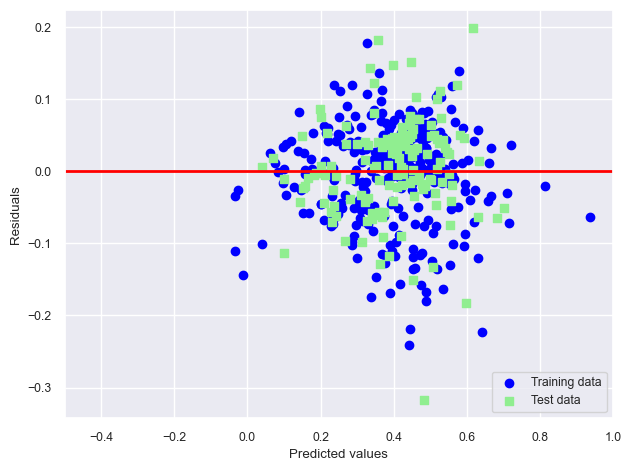

In [61]:
# Display the graph of the residuals
plt.scatter(y_train_pred,  y_train_pred - y_train, c = 'blue', marker = 'o', label = 'Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test, c = 'lightgreen', marker = 's', label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'lower right')
plt.hlines(y = 0.0, xmin = -0.5, xmax = 50, lw = 2, color = 'red')
plt.xlim([-0.5, 1])
plt.tight_layout()


plt.show()

In [62]:
# Calculate the r2_score and mean squared error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Display the means squared error and r2 score values
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 0.004, test: 0.005
R^2 train: 0.815, test: 0.766


In [63]:
y_test.head()

328    0.252308
469    0.359577
357    0.414918
54     0.372615
184    0.164177
Name: housing_price, dtype: float64

In [64]:
df_test_pred = pd.DataFrame(y_test_pred, columns=['Predicted'])


In [65]:
df_comparison = pd.concat([y_test, df_test_pred], axis=1)

In [66]:
df_comparison.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 328 to 143
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   housing_price  144 non-null    float64
 1   Predicted      144 non-null    float64
dtypes: float64(2)
memory usage: 5.7 KB


In [67]:
from scipy import stats

# t- test
t_statistic, p_value = stats.ttest_ind(df_comparison['housing_price'], df_comparison['Predicted'])

print("Statistiche t:", t_statistic)
print("Valore p:", p_value)


Statistiche t: nan
Valore p: nan


# Clustering

In [68]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler



In [69]:
final['TIME_PERIOD'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [70]:
final_year_2021 = final[final['TIME_PERIOD']== 2021]

In [71]:
final_year_2021.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 21 to 477
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   geo                                 23 non-null     object 
 1   TIME_PERIOD                         23 non-null     int64  
 2   housing_price                       23 non-null     float64
 3   Output price index in construction  23 non-null     float64
 4   investment in costruction           23 non-null     float64
 5   pro_capita__income                  23 non-null     int64  
 6   population                          23 non-null     float64
 7   alpha-3                             23 non-null     object 
 8   sub-region                          23 non-null     object 
 9   pro_capita__income_cat              23 non-null     object 
dtypes: float64(4), int64(2), object(4)
memory usage: 2.0+ KB


In [72]:
from sklearn.preprocessing import MinMaxScaler

#columns for normalization
columns_to_normalize = ['housing_price', 'Output price index in construction', 'investment in costruction', 'pro_capita__income', 'population']

scaler = MinMaxScaler()

final_year_2021[columns_to_normalize] = scaler.fit_transform(final_year_2021[columns_to_normalize])



In [73]:
final_year_2021=final_year_2021[final_year_2021['geo']!= 'HU']

In [74]:
final_year_2021.head()

,geo,TIME_PERIOD,housing_price,Output price index in construction,investment in costruction,pro_capita__income,population,alpha-3,sub-region,pro_capita__income_cat
21,AT,2021,0.478484,0.347273,0.581818,0.596710,0.100666,AUT,Western Europe,Y
43,BE,2021,0.229056,0.190909,0.763636,0.570414,0.132651,BEL,Western Europe,Y
78,CY,2021,0.012662,0.072727,1.000000,0.261411,0.003141,CYP,Western Asia,Y
100,CZ,2021,0.773039,0.296364,0.472727,0.239164,0.121813,CZE,Eastern Europe,Y
122,DE,2021,0.492193,0.387273,0.927273,0.707194,1.000000,DEU,Western Europe,Y


In [75]:
selected_columns = ['housing_price', 'Output price index in construction']

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# select two columns
col1 = final_year_2021['housing_price']
col2 = final_year_2021['Output price index in construction']

# create array with the columns
X = np.column_stack((col1, col2))




In [77]:
# build the clustering model
kmeans = KMeans(n_clusters = 3)

kmeans.fit(X)

KMeans(n_clusters=3)

In [78]:
kmeans.inertia_

0.3023705373998272

In [79]:
kmeans.cluster_centers_

array([[0.56978294, 0.35109091],
       [0.0278624 , 0.04727273],
       [0.33332276, 0.17919192]])

In [80]:
kmeans.n_iter_

4

1.3142013094800733
0.5084041370019297
0.3023705373998272
0.19660557853248714
0.12802925368562815
0.08189087329173476
0.0596306241458573
0.04439402610515142
0.03040861420731493
0.02185355524978103


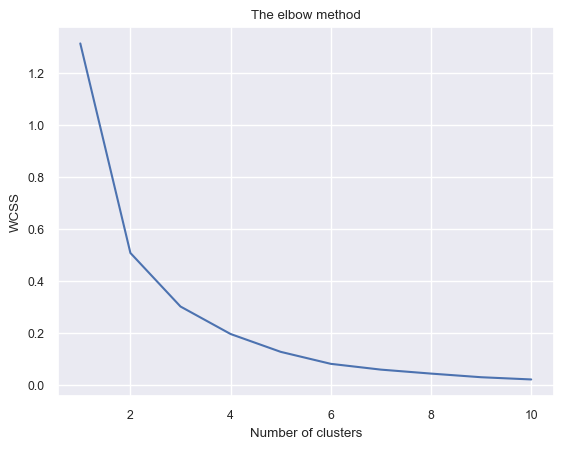

In [81]:
# Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []                  # Declare an array

# Set the loop from the minimum and maximum values
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    print(kmeans.inertia_)
# inertia_float: Sum of squared distances of samples to their closest cluster center.

# Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')    # within cluster sum of squares
plt.show()

In [82]:
# Define the model
kmeans_model = KMeans(n_clusters=4, random_state=32932)
# Fit into our dataset fit
kmeans_predict = kmeans_model.fit_predict(X)

In [84]:
final_year_2021['Cluster'] = kmeans_model.labels_ # add columns with clusters in the dataframe

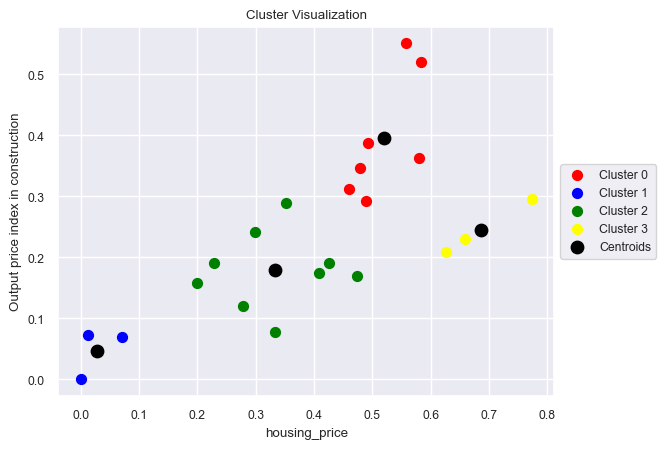

In [85]:
import matplotlib.pyplot as plt

# Plotting the clusters
plt.scatter(X[kmeans_predict == 0, 0], X[kmeans_predict == 0, 1], s=50, c='red', label='Cluster 0')
plt.scatter(X[kmeans_predict == 1, 0], X[kmeans_predict == 1, 1], s=50, c='blue', label='Cluster 1')
plt.scatter(X[kmeans_predict == 2, 0], X[kmeans_predict == 2, 1], s=50, c='green', label='Cluster 2')
plt.scatter(X[kmeans_predict == 3, 0], X[kmeans_predict == 3, 1], s=50, c='yellow', label='Cluster 3')
# Plotting the centroids
plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:, 1], s=80, c='black', label='Centroids')

plt.xlabel('housing_price')
plt.ylabel('Output price index in construction')
plt.title('Cluster Visualization')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [86]:
geo_cluster_1 = final_year_2021.loc[final_year_2021['Cluster'] == 1, 'geo']
print(geo_cluster_1.unique())


['CY' 'FI' 'IT']


In [87]:
geo_cluster_0 = final_year_2021.loc[final_year_2021['Cluster'] == 0, 'geo']
print(geo_cluster_0.unique())

['AT' 'DE' 'LT' 'LV' 'NL' 'SI' 'SK']


In [88]:
geo_cluster_2 = final_year_2021.loc[final_year_2021['Cluster'] == 2, 'geo']
print(geo_cluster_2.unique())

['BE' 'DK' 'EE' 'ES' 'FR' 'HR' 'IE' 'PL' 'SE']


In [89]:
geo_cluster_3 = final_year_2021.loc[final_year_2021['Cluster'] == 3, 'geo']
print(geo_cluster_3.unique())

['CZ' 'LU' 'PT']


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#  Silhoutte Score
score = silhouette_score(X, km.labels_, metric='euclidean')

print('Silhouetter Score: %.3f' % score)

In [90]:
final.head()

,geo,TIME_PERIOD,housing_price,Output price index in construction,investment in costruction,pro_capita__income,population,alpha-3,sub-region,pro_capita__income_cat
0,AT,2000,60.36,69.4,5.3,18096,8011.57,AUT,Western Europe,Y
1,AT,2001,60.82,70.5,4.9,18038,8042.29,AUT,Western Europe,Y
2,AT,2002,61.21,71.4,4.6,18604,8082.12,AUT,Western Europe,Y
3,AT,2003,61.36,72.4,4.4,19575,8118.25,AUT,Western Europe,Y
4,AT,2004,60.21,74.4,4.4,20217,8169.44,AUT,Western Europe,Y


# Dashboard

In [91]:
multi = final.melt(id_vars=['geo', 'TIME_PERIOD'], var_name='Indicator Name', value_name='Value')
multi.columns = ['country', 'time', 'variable', 'value']






In [92]:
from dash import Dash, html, dcc, Input, Output
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression
import numpy as np
import plotly.graph_objs as go
import dash_bootstrap_components as dbc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import warnings

In [93]:
def tab1_function():
    return html.Div(children = [

    html.Div([
    
    html.H2("Regression"),
    html.Div([    
    

    html.Div([
    html.H3('Data analysis'),
        
    html.Div([html.P("This chart allows  the user to dive into the data and explore the variables. First. select a variable from both  the x-axis and y-axis. The below chart will show a scatterplot and the regression fit, below you will find the equation of the regression fitas long as it is  ‘coefficient of determination’. The charts at the bottom will show the selected variables per year for a selected country. The visualization is interactive and you can pick the country in the scatterplot")],className="description"),
    ],className="simple_box"),

    html.Div([

        html.Div([
            html.Div('Select X variable for scatterplot', className="dd_title"),
            dcc.Dropdown(
                multi['variable'].unique(),
                'housing_price',
                id='filterx',
            ),
            dcc.RadioItems(
                ['Linear', 'Log'],
                'Linear',
                id='filterx2',
                labelStyle={'display': 'inline-block', 'marginTop': '5px'}
            )
        ],
        className="six columns"),

        html.Div([
            html.Div('Select Y variable for scatterplot', className="dd_title"),
            dcc.Dropdown(
                multi['variable'].unique(),
                'Output price index in construction',
                id='filtery'
            ),
            dcc.RadioItems(
                ['Linear', 'Log'],
                'Linear',
                id='filtery2',
                labelStyle={'display': 'inline-block', 'marginTop': '5px'}
            )
        ], className="six columns")
    ],className="row flex-display simple_box"),
    

    html.Div([
        
    html.Div([    
    html.Div([
        dcc.Graph(
            id='variablefilter',
            hoverData={'points': [{'customdata': 'IT'}]}
        ),
        dcc.Slider(
        multi['time'].min(),
        multi['time'].max(),
        step=None,
        id='yslider',
        value=multi['time'].max(),
        marks={str(year): str(year) for year in multi['time'].unique()}
        ),

        html.Div([
        html.Div(id = "regression", className="six columns"),
        html.Div(id = "equation", className="six columns")
        ],className="row flex-display text_appears")
            
    ], className="twelve columns simple_graph")
        
    
    
    
    ],className="row flex-display")   
    

        
    ],className="simple_box"),
        
    
    html.Div([""],className="separator")])],className="main_area"),


    html.Div([
    html.H2("X variable"),
    html.Div([
        dcc.Graph(id='xyears')
    ], className="simple_box")],className="main_area"),

    html.Div([
    html.H2("Y variable"),
    html.Div([
        dcc.Graph(id='yyears')
    ], className="simple_box")],className="main_area")

])





In [94]:
fig_hp = px.choropleth(final, locations="alpha-3",
                    color="housing_price", 
                    hover_name="geo", 
                    animation_frame="TIME_PERIOD", 
                    color_continuous_scale=px.colors.sequential.Plasma)

fig_hp.update_layout(
    geo={
        'center': {'lat': 51.980880, 'lon': 10.601220}
    }
)

fig_hp.update_geos(projection_scale=5)

def tab2_function():
    return html.Div(children = [

        html.Div([
        html.H2("Choropleth Map - Housing Price"),
        dcc.Graph(id='choropleth-graph', figure=fig_hp,style={'height': '800px'},className="simple_box")
        ],className="main_area"),

        html.Div([
        
        html.H2('K-means clusterings'),
        
        html.Div([
    
        
        
        html.H5('Visualize clustering of EU Countries by choosing the variables in the dropdown menu'),
        
        html.Div([
        html.P("This chart takes 2021 data and lets the user apply the k-means algorithm.  First, select a variable from both the x- axis and y- axis Variables are normalized and the countries are split in clusters based on the variables selected. You can select the quantity of clusters and the average silhouette score will help youassess the number .The range of this score is between -1 to + 1;the higher the score, the more defined the clusters")
        ],className="description")
        
        ],className="simple_box"),
        
        html.Div([
        html.Div(
            [
                dbc.Label("X variable", className="dd_title"),
                dcc.Dropdown(
                    id="x-variable",
                    options=[
                        {"label": col, "value": col} for col in final_year_2022.columns
                        
                    ],
                    value=" ",
                ),
            ], className="four columns"),
        
        html.Div(
            [
                dbc.Label("Y variable", className="dd_title"),
                dcc.Dropdown(
                    id="y-variable",
                    options=[
                        {"label": col, "value": col} for col in final_year_2022.columns
                    ],
                    value=" ",
                ),
            ], className="four columns"),
        
        html.Div(
            [
                dbc.Label("Cluster count", className="dd_title"),
                dbc.Input(id="cluster-count", type="number", value=3),
            ], className="four columns"),
        ], className="row flex-display simple_box"),
            
            
            html.Div([dcc.Graph(id="cluster-graph"),html.Div(id = "silhouette",className="text_appears")
            ], className="simple_box simple_graph row flex-display")

        ],className="main_area")
])





In [95]:
import dash
from dash import html, dcc, callback, Input, Output
from dash.dependencies import Input, Output


app = dash.Dash(__name__)



app.layout = html.Div([
    html.Div([
    html.H1('Dashboard con due tab')],className="header"),
    dcc.Tabs(id='tabs', value='tab-1', children=[
        dcc.Tab(label='Regression', value='tab-1'),
        dcc.Tab(label='Maps and Clustering', value='tab-2'),
    ]),
    html.Div(id='tab-content')
])


@app.callback(Output('tab-content', 'children'),
              [Input('tabs', 'value')])
def tab_switch(tab):
    
    if tab == 'tab-1':
        return tab1_function()
    elif tab == 'tab-2':
        return tab2_function()










# ------------------------------------------------------------------------------ start callback and functions tab 1






# functions and callback interactive graph
@app.callback(
    [Output('variablefilter', 'figure'),Output("regression", "children"),Output("equation", "children")],
    [Input('filterx', 'value'),
    Input('filtery', 'value'),
    Input('filterx2', 'value'),
    Input('filtery2', 'value'),
    Input('yslider', 'value')])
def update_variablefilter(xcolumns, ycolumns,
                 xtype, ytype,
                 year_):
    multi_df = multi[multi['time'] == year_]
    
    x=multi_df[multi_df['variable'] == xcolumns]['value']
    y=multi_df[multi_df['variable'] == ycolumns]['value']
    
    X = x.values.reshape(-1, 1)

    model = LinearRegression()
    model.fit(X, y)
    
    x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))
    
    r_sq = model.score(X, y)
    intercept = model.intercept_
    slope = model.coef_

    fig = px.scatter(multi,x,y,
            hover_name=multi_df[multi_df['variable'] == ycolumns]['country']
            )
    
    fig.add_traces(go.Scatter(x=x_range, y=y_range, name='Regression Fit'))

    fig.update_traces(customdata=multi_df[multi_df['variable'] == ycolumns]['country'])

    fig.update_xaxes(title=xcolumns, type='linear' if xtype == 'Linear' else 'log')

    fig.update_yaxes(title=ycolumns, type='linear' if ytype == 'Linear' else 'log')

    fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')
    
    r_sq = round(r_sq,3)
    
    regression = (f"coefficient of determination: {r_sq}") 
    
    intercept = round(intercept,3)
    
    
    
    equation = (f"intercept: {intercept}"), " ", (f"slope: {slope}")


    return fig,regression, equation





def years_time_series(multi_df, ax, sub):

    fig = px.scatter(multi_df, x='time', y='value')

    fig.update_traces(mode='lines+markers')

    fig.update_xaxes(showgrid=False)

    fig.update_yaxes(type='linear' if ax == 'Linear' else 'log')

    fig.add_annotation(x=0, y=0.85, xanchor='left', yanchor='bottom',
                       xref='paper', yref='paper', showarrow=False, align='left',
                       text=sub)

    fig.update_layout(height=225, margin={'l': 20, 'b': 30, 'r': 10, 't': 10})

    return fig

@app.callback(
    Output('xyears', 'figure'),
    Input('variablefilter', 'hoverData'),
    Input('filterx', 'value'),
    Input('filterx2', 'value'))
def ytime(hoverData, xcolumns, ax):
    country = hoverData['points'][0]['customdata']
    multi_df = multi[multi['country'] == country]
    multi_df = multi_df[multi_df['variable'] == xcolumns]
    sub = '<b>{}</b><br>{}'.format(country, xcolumns)
    return years_time_series(multi_df, ax, sub)


@app.callback(
    Output('yyears', 'figure'),
    Input('variablefilter', 'hoverData'),
    Input('filtery', 'value'),
    Input('filtery2', 'value'))
def xtime(hoverData, ycolumns, ax):
    multi_df = multi[multi['country'] == hoverData['points'][0]['customdata']]
    
    multi_df = multi_df[multi_df['variable'] == ycolumns]
    return years_time_series(multi_df, ax, ycolumns)



# ------------------------------------------------------------------------------ end callback and functions tab 1











# ------------------------------------------------------------------------------ start callback and functions tab 2




#function and callback for Housing Price Map

@app.callback(
    Output('choropleth-graph', 'figure'),
    [Input('dropdown-year', 'value')]
)
def update_map(year):
    # Filtra il DataFrame in base all'anno selezionato
    filtered_df = final[final['TIME_PERIOD'] == year]
    
    # Crea la nuova figura con choropleth
    updated_fig = px.choropleth(filtered_df, locations="alpha-3",
                                color="housing_price",
                                hover_name="geo",
                                color_continuous_scale=px.colors.sequential.Plasma)
    
    # Aggiorna il layout della figura
    updated_fig.update_layout(
        title_text=f"Housing Price - Year {year}",
        geo=dict(projection={'type': 'natural earth'})
    )
    
    return updated_fig



#function and callback clustering part

@app.callback(
    [Output("cluster-graph", "figure"),Output("silhouette", "children")],
    [
        Input("x-variable", "value"),
        Input("y-variable", "value"),
        Input("cluster-count", "value"),
    ]
)
def clu_make_graph(x, y, n_clusters):
    # minimal input validation, make sure there's at least one cluster
    km = KMeans(n_clusters)
    df = final_year_2021.loc[:, [x, y]]
    km.fit_predict(df)
    df["cluster"] = km.labels_

    centers = km.cluster_centers_

    data = [
        go.Scatter(
            x=df.loc[df.cluster == c, x],
            y=df.loc[df.cluster == c, y],
            
            mode='markers',
        
            marker={"size": 8},
            name="Cluster {}".format(c),
        )
        for c in range(n_clusters)
    ]

    data.append(
        go.Scatter(
            x=centers[:, 0],
            y=centers[:, 1],
            
            mode='markers+text',
            
           
            marker={"color": "#000", "size": 12, "symbol": "diamond"},
            name="Cluster centers",
        )
    )

    layout = {"xaxis": {"title": x}, "yaxis": {"title": y}}
    
    cluster_labels = km.fit_predict(df)
   

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df, cluster_labels)
    printd = (
        "For n_clusters = ",
        n_clusters,
        " The average silhouette_score is :",
        silhouette_avg,
    )
    
    clus = go.Figure(data=data, layout=layout)
   
    
    return clus,printd


# make sure that x and y values can't be the same variable
def clu_filter_options(v):
    """Disable option v"""
    return [
        {"label": col, "value": col, "disabled": col == v}
        for col in final_year_2021.columns
    ]


# functionality is the same for both dropdowns, so we reuse filter_options
app.callback(Output("x-variable", "options"), [Input("y-variable", "value")])(
    clu_filter_options
)
app.callback(Output("y-variable", "options"), [Input("x-variable", "value")])(
    clu_filter_options
)


# ------------------------------------------------------------------------------ end callback and functions tab 2



if __name__ == '__main__':
    app.run_server(port=8027, debug=False)


Dash is running on http://127.0.0.1:8027/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8027
Press CTRL+C to quit
127.0.0.1 - - [26/May/2023 22:19:38] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/May/2023 22:19:38] "GET /assets/style.css?m=1685132891.4675503 HTTP/1.1" 304 -
127.0.0.1 - - [26/May/2023 22:19:38] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [26/May/2023 22:19:38] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [26/May/2023 22:19:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/May/2023 22:19:39] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [26/May/2023 22:19:39] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [26/May/2023 22:19:39] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [26/May/2023 22:19:39] "GET /_dash-component-suites/dash/dcc/async-slider.js HTTP/1.1" 304 -
127.0.0.1 - - [26/May/2023 22:19:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/May/2023 22:19:39] "P